# OilyGiant site analysis predictive model

## Introduction
This is a model built to predict the region with the most earning potential for the OilyGiant mining company.  It analyzes oil well parameters using a cross-verified linear regression model to predict volumes of oil reserves.  It then estimates the potential profits based on those volumes.

After preprocessing the data and vizualizing the data distribution in each region, we will explore the best 200 points in each region to gain insight into the potential profit and risk of loss within a 95% confidence interval. Taking this risk and potential profit into account, I will select the region most-likely to be fruitful.

In [20]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


## Data Preprocessing

I'll import the data for each region, then loop through each looking at it's overall characteristics to determine how to process it for modeling. 

In [21]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [22]:
data_sets = [data_0, data_1, data_2]
for data in data_sets:
    print(data.shape)
    print()
    print(data.info())
    print()
    print(data.describe())
    print()

(100000, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.36233

There do not appear to be any missing values, and all features appear to be numerical.

## Check for duplicates

There no full row duplicates, however there are a handful of ID's in each region that appear more than once. For our model, we need ID's to be unique, so I'll remove the duplicates. 

In [23]:
for data in data_sets:
    print(data.duplicated().sum())
    print(data['id'].duplicated().sum())
    print()

0
10

0
4

0
4



In [24]:
for data in data_sets:
    data.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [25]:
# Reviewer's code

data['id'].duplicated().sum()

0

## Visualize each region's data

Let's look at the distribution of data in each dataset.  Preliminarily, region 1 appears to have the most relational regularity amongst it's numerical data. Let's explore this early visual clue further utilizing a linear regression model.

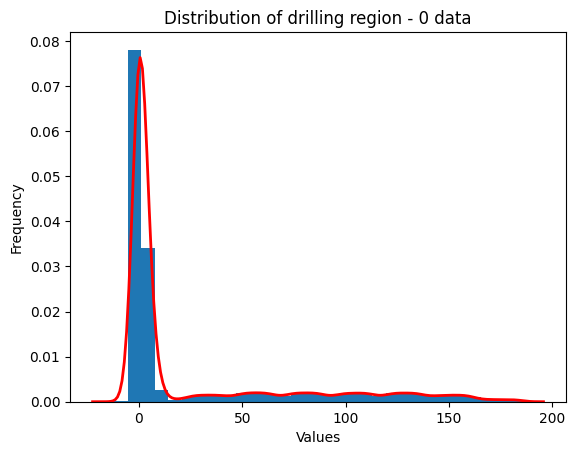

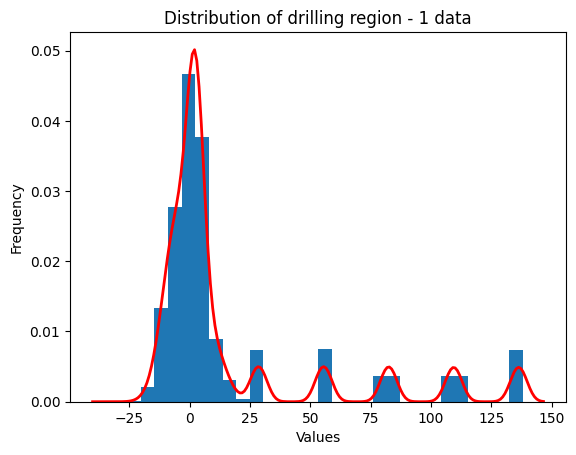

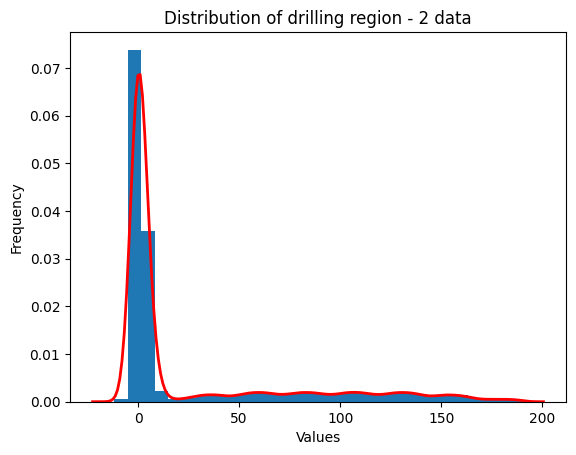

In [26]:
i = 0
for data in data_sets:
    sns.distplot(data.drop(['id'], axis=1), bins=30, hist_kws={'alpha': 1}, kde_kws={'lw': 2, 'color': 'r'})
    plt.title(f'Distribution of drilling region - {i} data')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()
    i += 1

## Train, Test, and Cross-validate a Linear Regression model

I'll use the modules from the sklearn library in this function to scale the data and split it into training and testing sets.  I will also use the cross_val_score module from sklearn to cross validate the model, as well as evaluate the model using the root mean squared error (RMSE) and R2 score for each of the 3 regions (0, 1, 2).  As expected from the above distribution charts, region 1 has, by far the best model with an RMSE of almost 90%, and R2 & average model eval of almost 100%. However, region 1's reserve volume is appreciably lower than both regions 0 & 2.

In [27]:

def loc_model(data):
    features = data[['f0', 'f1', 'f2']]
    target = data['product']
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    
    avg_vol = pred.mean()
    rmse = mean_squared_error(target_test, pred)**0.5
    score = r2_score(target_test, pred)
    ans = pd.Series(target_test).reset_index(drop=True)
    
    
    cv_scores = cross_val_score(model, features_train, target_train, cv=5)
    final_score = sum(cv_scores)/len(cv_scores)
    
    print('Average predicted reserve volume:', avg_vol)
    print('RMSE:', rmse)
    print('R2 score:', score)
    print('Average Model Evaluation Score:', final_score)
    print()
    
    return pd.Series(pred), ans, model, avg_vol

In [28]:
loc0_pred, loc0_ans, loc0_model, loc0_avg_vol = loc_model(data_0)

Average predicted reserve volume: 92.78915638280621
RMSE: 37.853527328872964
R2 score: 0.2723923460817068
Average Model Evaluation Score: 0.27659260309400285



In [29]:
loc1_pred, loc1_ans, loc1_model, loc1_avg_vol = loc_model(data_1)

Average predicted reserve volume: 69.1783195703043
RMSE: 0.8920592647717033
R2 score: 0.9996222988190184
Average Model Evaluation Score: 0.9996250581117107



In [30]:
loc2_pred, loc2_ans, loc2_model, loc2_avg_vol = loc_model(data_2)

Average predicted reserve volume: 94.86572480562035
RMSE: 40.07585073246016
R2 score: 0.19556241810202346
Average Model Evaluation Score: 0.19970983177482343



## Values and volume predictions

Each barrel of oil equates to 4.5 USD, and each unit consists of 1000 oil barrels, thus the revenue from each unit of oil = 4500 USD.  The cost to equip a region for oil extraction is 100,000,000 USD.  We see that the minimum volume of oil needed for a region to avoid a potential loss is 22,222 units of oil.  Using the average volumes predicted by our model for 200 sites in each region we see that none of the regions look profitable.  I'll isolate the 200 sites per region with the most volume moving forward, so the profitability should be higher than the averages.

In [31]:
prod_unit = 4500
budget = 10**8

no_loss_vol = budget / prod_unit
print(int(no_loss_vol))

22222


In [32]:
vol_per_region = [loc0_avg_vol, loc1_avg_vol, loc2_avg_vol]

i = 0
for region in vol_per_region:
    print(f'Average Reserve Volume Region {i}:', round(region*200))
    print()
    i += 1

Average Reserve Volume Region 0: 18558

Average Reserve Volume Region 1: 13836

Average Reserve Volume Region 2: 18973



## Calculate profit

Isloting the top 200 sites with the most reserves for each region, I'll use the function below to calculate potential volume and profit.  Now each region shows as potentially profitable, with region 0 having the most potential at an estimated 33 million in operating profit. Also somewhat of a revelation from the previous estimation, region 1, although still maintaining the lowest reserve volume, has caught up to the pack in relation to the other two regions when evaluating it's top 200 sites. 

In [33]:
def select_well_profits(pred, ans, show='yes'):
    top_pred_sites = pred.sort_values(ascending=False).head(200).index
    sites_vol = ans[top_pred_sites].sum()
    gross_prof = sites_vol * prod_unit
    op_prof = gross_prof - budget
    if show=='yes':
        print('Reserve Volume:', sites_vol)
        print('Operating Profit:', op_prof)
    return op_prof

In [34]:
predictions = [loc0_pred, loc1_pred, loc2_pred]
answers = [loc0_ans, loc1_ans, loc2_ans]
i = 0
for j,k in zip(predictions, answers):
    print(f'Region {i}') 
    select_well_profits(j, k)
    print()
    
    i += 1

Region 0
Reserve Volume: 29700.416083778415
Operating Profit: 33651872.377002865

Region 1
Reserve Volume: 27589.081548181137
Operating Profit: 24150866.966815114

Region 2
Reserve Volume: 27780.63078507125
Operating Profit: 25012838.532820627



## Bootstrapping 

I will further evaluate the efficacy of our linear regression model using the bootstrapping function below.  Propagating values from subsamples of the source set of predictions and answers, I will extract the average profit within a 95% confidence interval, as well as the upper and lower profits at the ends of that interval to then assess a risk percentage of loss in each region.

In [35]:
#Bootstrap fxn to assess model confidence
def bootstrap(pred, ans):
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        ans_subsample = ans.sample(n=500, replace=True, random_state=state)
        pred_subsample = pred[ans_subsample.index]
        prof = select_well_profits(pred_subsample, ans_subsample, show='no')
        values.append(prof)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    mean = values.mean()
    
    print('Average Profit: $', round(mean))
    print('Lower Profit at 95% Confidence: $', round(lower))
    print('Upper Profit at 95% Confidence: $', round(upper))
    
    total_prof = 0
    for i in range(1, 100):
        prof = values.quantile(i/1000)
        if prof >= 0:
            total_prof = prof
            total_i = i
            break
    print(f'Risk of Loss: {i/10}%')    

In [36]:
#Run each region through the bootstrap fxn
i = 0
for j,k in zip(predictions, answers):
    print(f'Region {i}') 
    bootstrap(j, k)
    print()
    
    i += 1

Region 0
Average Profit: $ 5856523
Lower Profit at 95% Confidence: $ -58784
Upper Profit at 95% Confidence: $ 12792401
Risk of Loss: 2.8%

Region 1
Average Profit: $ 6822983
Lower Profit at 95% Confidence: $ 1857996
Upper Profit at 95% Confidence: $ 12476845
Risk of Loss: 0.3%

Region 2
Average Profit: $ 5379665
Lower Profit at 95% Confidence: $ -696510
Upper Profit at 95% Confidence: $ 11679714
Risk of Loss: 4.1%



## Conclusion

After preprocessing and visualizing our data, training and evaluating our linear regression model, calculating reserve volumes and profits for each region we are ready to look at the outcomes from our bootstrapping efforts.

Region 1 has the lowest risk of loss at 0.3%, where the other two regions have risk many times that percentage at 2-4%. Region 1 also has the highest lower interval profit at 1.6 million USD.  While given region 1 does not have the highest possible potential upside, with both other regions holding more than 300,000 USD in additional potential revenue, it's predictability and low propensity for profit loss make it my first reccommendation for OilyGiants next well development.  